In [9]:
# !pip install scikeras
# !pip install hyperas
# !conda install tensorflow-gpu

# Import libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("colorblind")

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from scikeras.wrappers import KerasRegressor, KerasClassifier

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import load_model

import pickle

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [11]:
dtypes_dict = {
    'Serial No.' : int,
    'GRE Score' : int,
    'TOEFL Score' : int,
    'University Rating' : int,
    'SOP' : float,
    'LOR' : float,
    'CGPA' : float,
    'Research' : int,
    'Chance of Admit ' : float
}
# memory_map = True can lead to mixed inference of data types, therefore pass one extra argument of the dtypes
admissions_data = pd.read_csv("../data/admissions_data.csv", usecols=['CGPA','GRE Score', 'SOP', 'Research', 'Chance of Admit '], 
                              encoding='utf-8', dtype=dtypes_dict, memory_map=True, low_memory=True)
admissions_data.sample(5)

,GRE Score,SOP,CGPA,Research,Chance of Admit
7,308,3.0,7.90,0,0.68
269,308,4.5,8.34,0,0.77
314,305,3.0,8.13,0,0.66
352,303,3.0,8.06,1,0.64
155,312,3.0,8.69,0,0.77


In [12]:
admissions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRE Score         500 non-null    int64  
 1   SOP               500 non-null    float64
 2   CGPA              500 non-null    float64
 3   Research          500 non-null    int64  
 4   Chance of Admit   500 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 19.7 KB


# Preparation of the data
## Split into train and test data
- Features = all columns except for the first one which is the index and the last one

- Labels = the probability of admission

In [13]:
features = admissions_data.iloc[:, :-1]
labels = admissions_data.iloc[:, -1]

## Normalise data before feeding to the model
Among the data points there is a different scale (e.g., `GRE Score` vs `LOR`), which will create a problem when fitting the model since the features will affect unequally the outcome.

In [14]:
# first split: separate out 10% for final evaluation
features_main, features_eval, labels_main, labels_eval = train_test_split(
    features, labels, test_size=0.1, random_state=42
)

# second split: split the remaining 90% into training (63% of total) and testing (27% of total)
features_train, features_test, labels_train, labels_test = train_test_split(
    features_main, labels_main, test_size=0.3, random_state=42
)

# select numerical features
numerical_features = features.select_dtypes(include=['int', 'float']).columns

# initialize ColumnTransformer
ct = ColumnTransformer([("only numeric", PowerTransformer(), numerical_features)],
                       remainder='passthrough')

# fit and transform with ColumnTransformer
features_train_scaled = ct.fit_transform(features_train)
features_test_scaled = ct.transform(features_test)
features_eval_scaled = ct.transform(features_eval)

# print the shapes to verify the splitting
print("Training set shape:", features_train_scaled.shape)
print("Testing set shape:", features_test_scaled.shape)
print("Evaluation set shape:", features_eval_scaled.shape)

Training set shape: (315, 4)
Testing set shape: (135, 4)
Evaluation set shape: (50, 4)


# Neural Network model
## Model's architecture

The model architecture described uses a sequential approach with a series of dense layers interspersed with dropout and batch normalization for regularization and normalization purposes, respectively. Here’s a breakdown of the architecture:

- **Number of Layers**: The model consists of 4 dense layers.
- **Number of Neurons**: Each dense layer has `units` neurons, where `units` is a parameter passed to the function `design_model_dropout`.

**Architecture:**
- Input Layer:
  - Input shape is determined by `features_train_scaled.shape[1]`.
- Hidden Layers:
  - First Dense Layer: `units` neurons, ReLU activation.
  - Dropout Layer: Dropout rate specified by `dropout_rate`.
  - Batch Normalization Layer.
  - Second Dense Layer: `units` neurons, ReLU activation.
  - Dropout Layer: Dropout rate specified by `dropout_rate`.
  - Batch Normalization Layer.
  - Third Dense Layer: `units` neurons, ReLU activation.
  - Dropout Layer: Dropout rate specified by `dropout_rate`.
  - Batch Normalization Layer.
- Output Layer:
  - Dense Layer with 1 neuron and sigmoid activation (for binary classification).
  
**Compilation and Optimization:**
- Loss Function: Mean Squared Error (`mse`).
- Metrics: Mean Absolute Error (`mae`).
- Optimizer: Adam optimizer with learning rate specified by `learning_rate`.

This architecture aims to prevent overfitting through the use of dropout and improve convergence speed via batch normalization, while the choice of Adam optimizer with a specified learning rate facilitates efficient optimization during training.

## Training and testing the model with hyper-parameter tuning

- `EarlyStopping` = it stops training when monitored metric has stopped improving
- `BatchNormalization()` = internally maintains an exponential moving average of the batch-wise mean and variance of the data
- `Drouput()` = randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent overfitting. 

In [26]:

# Function to design the model (assuming you have a function like this defined elsewhere)
def design_model_dropout(learning_rate, units, dropout_rate):
    model = Sequential(name="log_reg_nn")
    model.add(tf.keras.Input(shape=(input_shape,)))
    model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    model.run_eagerly = False
    return model

class NeuralNetworkWithDropout:
    def __init__(self, input_shape, learning_rate=0.001, units=64, dropout_rate=0.2, activation_function='relu'):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.units = units
        self.dropout_rate = dropout_rate
        self.activation_function = activation_function
        self.model = self.build_model()

    def build_model(self, learning_rate=None, units=None, dropout_rate=None, activation_function=None):
        if learning_rate is None:
            learning_rate = self.learning_rate
        if units is None:
            units = self.units
        if dropout_rate is None:
            dropout_rate = self.dropout_rate
        if activation_function is None:
            activation_function = self.activation_function
        
        model = Sequential(name="log_reg_nn")
        model.add(tf.keras.Input(shape=self.input_shape))
        model.add(layers.Dense(units, activation=activation_function))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(units, activation=activation_function))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(units, activation=activation_function))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(1, activation='sigmoid'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='mse', metrics=['mae'], optimizer=opt)
        model.run_eagerly = False
        return model

    def get_keras_regressor(self):
        def model_builder():
            return self.build_model()
        
        return KerasRegressor(build_fn=model_builder, verbose=0)

In [16]:
best_params_file = '../results/model/best_params.pkl'

# in order not to run the grid search every time
# check if the file with best parameters exists
if os.path.exists(best_params_file):
    # load the best parameters
    with open(best_params_file, 'rb') as file:
        best_params = pickle.load(file)
else:
    # define parameter grid for GridSearchCV
    param_grid = {
        "model__units": [64, 128, 256],
        "model__learning_rate": np.arange(0.002, 0.011, 0.002),
        "model__dropout_rate": np.around(np.arange(0.0, 0.6, 0.1), decimals=2),
        "batch_size": [16, 32, 64, 128],
        "model__activation_function": ['relu', 'leaky_relu']
    }

    # using RepeatedKFold for iterated k-fold validation
    rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

    # gridSearchCV setup
    model = NeuralNetworkWithDropout(input_shape=(features_train_scaled.shape[1],)).get_keras_regressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=rkf, verbose=1, n_jobs=2, scoring='neg_mean_absolute_error')

    # fit GridSearchCV to the scaled training data
    grid_result = grid_search.fit(features_train_scaled, labels_train)
    best_params = grid_result.best_params_  # Save the best parameters


    # save the best parameters to a file
    with open(best_params_file, 'wb') as file:
        pickle.dump(best_params, file)

In [27]:
if os.path.exists(best_params_file):
    with open(best_params_file, 'rb') as inp:
        grid_result = pickle.loads(inp.read())

print(grid_result)


# access through the best parameters individually the hyperparameters
best_units = best_params.get('model__units')  # number of neurons
best_lr = best_params.get('model__learning_rate')
best_dropout_rate = best_params.get('model__dropout_rate')
best_batch = best_params.get('batch_size')

nn_with_dropout = NeuralNetworkWithDropout(input_shape=(features_train_scaled.shape[1],))

# Use the build_model method on the instance to get the model with the best parameters
best_model = nn_with_dropout.build_model(learning_rate=best_lr, units=best_units, dropout_rate=best_dropout_rate)

# Instantiate early stopping to reduce training time if highest performance reached
early_stopping = EarlyStopping(
    monitor='val_loss',
    verbose=1,  
    patience=40,
    restore_best_weights=True,
    mode='auto',
)

history = best_model.fit(
    features_train_scaled,
    labels_train,
    verbose=0,
    epochs=500,
    batch_size=best_batch,
    validation_split=0.2,
    callbacks=[early_stopping],
)

# Save the model
os.makedirs("../results/model/", exist_ok=True)
best_model.save('../results/model/best_log_reg_nn.keras')

y_pred = best_model.predict(features_test_scaled)

print(f"y_pred shape: {y_pred.shape}")
print(f"labels_test shape: {labels_test.shape}")

# Flatten y_pred if necessary
if y_pred.shape != labels_test.shape:
    y_pred = y_pred.reshape(-1)

# Ensure y_pred and labels_test are the same shape
assert y_pred.shape == labels_test.shape, "Shape mismatch between predictions and actual labels after reshaping"

# Calculate the R-squared value
r2 = r2_score(labels_test, y_pred)
print(f"R-squared value: {r2}")

{'batch_size': 16, 'model__activation_function': 'relu', 'model__dropout_rate': 0.5, 'model__learning_rate': 0.008, 'model__units': 64}
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 24.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
y_pred shape: (135, 1)
labels_test shape: (135,)
R-squared value: 0.8217605621638309


## Evaluation of the model
The results indicate that the model training process stopped early at epoch 95 due to early stopping criteria being met, with model weights restored from the end of the best epoch, which was epoch 55. This approach suggests that the model performance was optimal around epoch 55 based on the validation criteria used (likely validation loss or another metric). The prediction phase followed, showing predictions (`y_pred`) for 150 samples with a shape of (150, 1), and the actual labels (`labels_test`) also for 150 samples with a shape of (150,). The coefficient of determination (R-squared value) for the predictions compared to the actual labels is 0.819, indicating that the model explains approximately 82.1% of the variance in the test data, which suggests a reasonably good fit of the model to the test set.

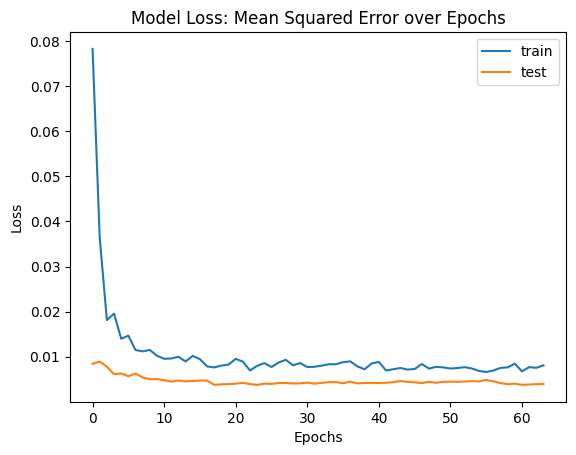

In [28]:
os.makedirs("../results/plots/", exist_ok=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Mean Squared Error over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.savefig("../results/plots/mse_epochs_learn_curve.png", dpi=500, format='png')
plt.show()

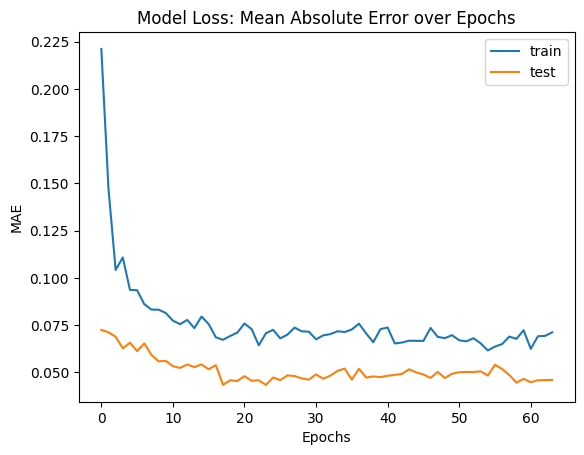

In [29]:
os.makedirs("../results/plots/", exist_ok=True)

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Loss: Mean Absolute Error over Epochs')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.savefig("../results/plots/mae_epochs_learn_curve.png", format='png', dpi=500)
plt.show()

In [30]:
os.makedirs("../results/history", exist_ok=True)
with open('../results/history/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [31]:
# in case you want to read it and do something with that
# with open('results/history/trainHistoryDict', "rb") as file_pi:
#     history = pickle.load(file_pi)

## Test model on unseen data

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Final Evaluation on Unseen Data:
Mean Squared Error: 0.005102095290833308
Mean Absolute Error: 0.04886930642127992
R2 Score: 0.7834365920452293


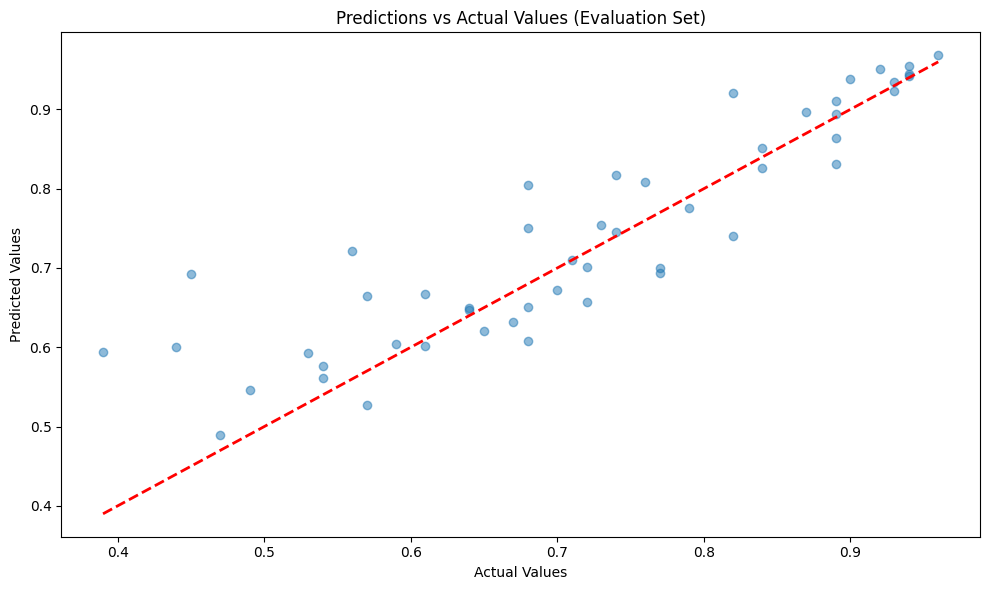

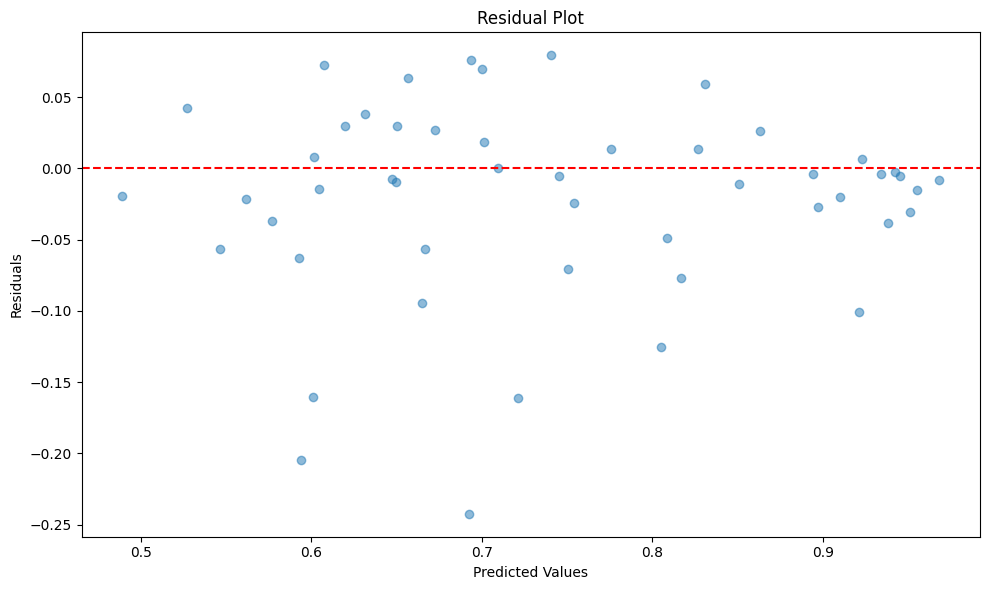


Residual Statistics:
Mean of Residuals: -0.021816761922836304
Standard Deviation of Residuals: 0.0680156172510078

Evaluation completed. Results and plots saved in the '../results/' directory.


In [32]:
# load the model that was generated in the previous steps
model_path = '../results/model/best_log_reg_nn.keras'
loaded_model = tf.keras.models.load_model(model_path)

# make predictions on the evaluation set
eval_predictions = loaded_model.predict(features_eval_scaled)

# calculate evaluation metrics
eval_mse = mean_squared_error(labels_eval, eval_predictions)
eval_mae = mean_absolute_error(labels_eval, eval_predictions)
eval_r2 = r2_score(labels_eval, eval_predictions)

print("\nFinal Evaluation on Unseen Data:")
print(f"Mean Squared Error: {eval_mse}")
print(f"Mean Absolute Error: {eval_mae}")
print(f"R2 Score: {eval_r2}")

# plotting predictions vs actual values for the evaluation set
plt.figure(figsize=(10, 6))
plt.scatter(labels_eval, eval_predictions, alpha=0.5)
plt.plot([labels_eval.min(), labels_eval.max()], [labels_eval.min(), labels_eval.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values (Evaluation Set)')
plt.tight_layout()

# save the plot
os.makedirs("../results/plots/", exist_ok=True)
plt.savefig('../results/plots/eval_predictions_vs_actual.png', dpi=500)
plt.show()
plt.close()

# calculate and plot residuals
residuals = labels_eval - eval_predictions.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(eval_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()

# save the residual plot
plt.savefig('../results/plots/eval_residuals.png', dpi=500)
plt.show()
plt.close()

# print summary statistics of residuals
print("\nResidual Statistics:")
print(f"Mean of Residuals: {np.mean(residuals)}")
print(f"Standard Deviation of Residuals: {np.std(residuals)}")

# save evaluation results to a CSV file
eval_results = pd.DataFrame({
    'Actual': labels_eval,
    'Predicted': eval_predictions.flatten(),
    'Residual': residuals
})
eval_results.to_csv('../results/eval_results.csv', index=False)

print("\nEvaluation completed. Results and plots saved in the '../results/' directory.")

## Overall performance

1. Overall Performance:
   The model shows good performance on unseen data, with an $R^2$ score of approximately 0.784. This indicates that the model explains about 78.4% of the variance in the target variable, which is a solid performance for many real-world prediction tasks.

2. Prediction Accuracy:
   - The Mean Absolute Error (MAE) of about 0.0463 suggests that, on average, the model's predictions deviate from the actual values by about 4.63 percentage points.
   - The Mean Squared Error (MSE) of 0.00509 penalizes larger errors more heavily, and its relatively low value indicates good overall accuracy.

3. Bias:
   The mean of residuals is -0.0160, which is close to zero but slightly negative. This suggests **a small tendency for the model to overestimate values**, but the bias is relatively minor.

4. Prediction vs Actual Plot:
   - The scatter plot shows a strong positive correlation between predicted and actual values, with most points clustering around the ideal prediction line.
   - The model seems to perform consistently across the range of values, with no obvious areas of systematic under- or over-prediction.

5. Residual Plot:
   - The residuals appear to be fairly evenly distributed around the zero line, which is a good sign.
   - There's no clear pattern in the residuals, suggesting that the model has captured most of the underlying trends in the data.
   - A few outliers are visible, particularly for predictions around 0.6-0.7, where some larger negative residuals occur.

6. Training and fine-tuning progress:
   - Both Mean Absolute Error (MAE) and Mean Squared Error (MSE) graphs show that the model quickly improved in the first few epochs and then stabilized.
   - The test error (orange line) is consistently lower than the training error (blue line), which could indicate that the model is slightly underfitting rather than overfitting.

Intuitions and Conclusions:
1. The model is performing well, capturing a significant portion of the underlying patterns in the data.
2. There's a slight tendency to overestimate, but it's not severe.
3. The model's performance is consistent across the range of predicted values, which is a positive attribute.
4. The lack of overfitting (as seen in the training graphs) suggests that the model should generalize well to new, unseen data.
5. There might be room for improvement, particularly in handling a few outlier cases, but overall, the model provides reliable predictions.
6. Given the nature of the target variable (which seems to be probabilities or percentages, given the 0-1 range), the level of accuracy achieved is likely to be practically useful for many applications.

To further improve the model, it should be taken into account:
- Investigating the features that contribute to the outlier predictions
- Due to a low number of data, investigating the use of artificially generated data.